In [88]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

%matplotlib inline

# Data Recreation

In [67]:
#First, load the individual user data (we will assign new user_id's and we need their political stance)
user_data = pd.read_csv('users_final.csv')
user_data['user_id'] = user_data['mturk']
user_data['user_key'] = user_data.index

user_data[['user_id','political_stand','user_key']].head()

,user_id,political_stand,user_key
0,5c34e423-8d6e-4a62-b4be-f8755748a2eb,strong Democrats,0
1,5c34ea5d-82ff-4f65-bee8-2ca4eb2848db,Republicans,1
2,5c34f29d-90b0-4c04-b78c-959b16f1c0d6,strong Democrats,2
3,5c34f45d-408d-4388-a655-f44a14991304,strong Democrats,3
4,5c34f905-a310-47cd-bf2b-324cf95e4adb,strong Democrats,4


In [195]:
#Load the answer data, and get extra columns used in later group by's
answer_data = pd.read_csv('answers_final.csv')

#Filter out Irrelevant Rows
answer_data = answer_data[answer_data['world_id'] != 0] #No World Z
answer_data = answer_data.iloc[:,:-2] #Remove false D & R columns

#Join in user_id's and political stance
answer_data = answer_data.join(user_data[['user_id','political_stand','user_key']].set_index('user_id'),on='user_id').reset_index()

#Get Order Grouped By Question & World
within_wq_order = []
q_dict = {q:0 for q in answer_data['question_id'].unique()}
counter_dict = {world:q_dict.copy() for world in sorted((answer_data['world_id'].unique()))}

for i in tqdm(range(len(answer_data))):
    data = answer_data.iloc[i].copy()

    world = data['world_id']
    question = data['question_id']    
    
    counter_dict[world][question] += 1
    within_wq_order += [counter_dict[world][question]]
    
answer_data['within_wq_order'] = within_wq_order

#Re-sort, Filter, & re-name the columns
answer_data = answer_data[['world_id','question_id','within_wq_order','user_key','index','user_political_stand','political_stand']]
answer_data.columns = ['world','question','wq_order','user_order','q_order','response','pol']

#Rename strings into values
answer_data['pol'] = answer_data['pol'].replace({'strong Democrats':-2, 'Democrats':-1,
                                                 'strong Republicans':+2, 'Republicans':+1})
answer_data['response'] = answer_data['response'].replace({'disagree':0, 'agree':1})

answer_data.head(10)

100%|██████████| 47298/47298 [00:20<00:00, 2351.64it/s]


,world,question,wq_order,user_order,q_order,response,pol
0,7,23,1,0,0,0.0,-2.0
1,7,18,1,0,1,0.0,-2.0
2,7,17,1,0,2,1.0,-2.0
3,7,6,1,0,3,1.0,-2.0
4,7,15,1,0,4,0.0,-2.0
5,7,12,1,0,5,0.0,-2.0
6,7,14,1,0,6,1.0,-2.0
7,7,20,1,0,7,1.0,-2.0
8,7,8,1,0,8,0.0,-2.0
9,7,9,1,0,9,0.0,-2.0


In [196]:
#Filter only on Q's 1-20
answer_data = answer_data[answer_data['question'] >= 1]
answer_data = answer_data[answer_data['question'] <= 20]

#Remove 'NaN's in response and politics
answer_data = answer_data.dropna()
 
#Sort by world and question order
answer_data = answer_data.sort_values('wq_order').sort_values(['world','question'])

In [227]:
#Generate a correct "conform", "D", "R", and "winner" columns

D_percent_list = [] #What is the current running % for Democrats
R_percent_list = [] #What is the current running % for Republican

winner_list = [] #Did D's or R's have the higher number (or was it equal?)
conform_col = [] #Did a user's (dis)agreement conform or rebel (or was the %'s equal at the time)

for w in tqdm(sorted(answer_data['world'].unique())):
    world_data = answer_data[answer_data['world'] == w]
    
    for q in sorted(world_data['question'].unique()):
        question_data = world_data[world_data['question'] == q]
        
        D, R = [], []
        
        for i,idx in enumerate(question_data.index):
            row = question_data.loc[idx]
            
            #Get the percent agreement
            D_percent = np.mean(D) if len(D) > 0 else 0.5
            R_percent = np.mean(R) if len(R) > 0 else 0.5

            #If Democrats & Republicans are "tied"
            if D_percent == R_percent:
                conform_col += ['equal']
                winner = 'equal'

            #If Democrats are "winning"
            elif D_percent > R_percent:
                winner = 'democrats'
                if (((row['pol'] < 0) & (row['response'] == 1)) or   #Democrat & Agree
                   ((row['pol'] > 0) & (row['response'] == 0))):     #Republican & Disagree
                    conform_col += ['conform']
                elif (((row['pol'] < 0) & (row['response'] == 0)) or #Democrat & Disagree
                     ((row['pol'] > 0) & (row['response'] == 1))):   #Republican & Agree
                    conform_col += ['rebel']

            #If Republicans are "winning"
            else:                    
                winner = 'republicans'
                if (((row['pol'] < 0) & (row['response'] == 0)) or  #Democrat & Disagree
                    ((row['pol'] > 0) & (row['response'] == 1))):    #Republican & Agree
                    conform_col += ['conform']
                elif (((row['pol'] < 0) & (row['response'] == 1)) or #Democrat & Agree
                     ((row['pol'] > 0) & (row['response'] == 0))):   #Republican & Disagree
                    conform_col += ['rebel']                   

            #Also add in D, R and Winner list
            D_percent_list += [np.mean(D) if len(D) > 0 else 0.5]
            R_percent_list += [np.mean(R) if len(R) > 0 else 0.5]
            winner_list += [winner]
            
            #Add to the running list of responses
            if row['pol'] < 0:
                D += [row['response']]
            else:
                R += [row['response']]
                


100%|██████████| 10/10 [00:21<00:00,  2.11s/it]


In [228]:
#Add in the columns

answer_data['conform'] = conform_col
answer_data['D%'] = D_percent_list
answer_data['R%'] = R_percent_list
answer_data['winner'] = winner_list

answer_data

,world,question,wq_order,user_order,q_order,response,pol,conform,D%,R%,winner
37,1,1,1,1,37,0.0,1.0,equal,0.500000,0.500000,equal
280,1,1,2,14,280,1.0,1.0,rebel,0.500000,0.000000,democrats
342,1,1,3,20,342,0.0,-1.0,equal,0.500000,0.500000,equal
669,1,1,4,36,669,0.0,2.0,rebel,0.000000,0.500000,republicans
783,1,1,5,41,783,0.0,1.0,rebel,0.000000,0.333333,republicans
1127,1,1,6,65,1127,1.0,-2.0,rebel,0.000000,0.250000,republicans
1199,1,1,7,69,1199,0.0,-2.0,rebel,0.500000,0.250000,democrats
1565,1,1,8,86,1565,0.0,2.0,conform,0.333333,0.250000,democrats
1737,1,1,9,94,1737,0.0,-1.0,rebel,0.333333,0.200000,democrats
1902,1,1,10,103,1902,1.0,2.0,rebel,0.250000,0.200000,democrats


In [573]:
answer_data.to_csv('answer_data.csv')

# Figure 1

In [370]:
ind_data = answer_data[answer_data['world'] <=2]

ind_data = ind_data[ind_data['conform'] != 'equal'].groupby(['pol']).count()[['world']].join(
                ind_data[ind_data['conform'] == 'conform'].groupby(['pol']).count()[['question']])

ind_data.columns = ['total','conform']

ind_data['conf'] = ind_data['conform'] / ind_data['total'] - 0.5

ind_data.head()

,total,conform,conf
pol,,,
-2.0,2137,1013,-0.025971
-1.0,1806,851,-0.028793
1.0,2482,1331,0.036261
2.0,1970,1116,0.066497


In [408]:
inf_data = answer_data[answer_data['world'] > 2]

inf_data = inf_data[inf_data['conform'] != 'equal'].groupby(['pol']).count()[['world']].join(
                inf_data[inf_data['conform'] == 'conform'].groupby(['pol']).count()[['question']])

inf_data.columns = ['total','conform']

inf_data['conf'] = inf_data['conform'] / inf_data['total'] - 0.5

inf_data.head()

,total,conform,conf
pol,,,
-2.0,8159,5034,0.116987
-1.0,8222,4781,0.081489
1.0,10278,6349,0.117727
2.0,7028,4728,0.172738


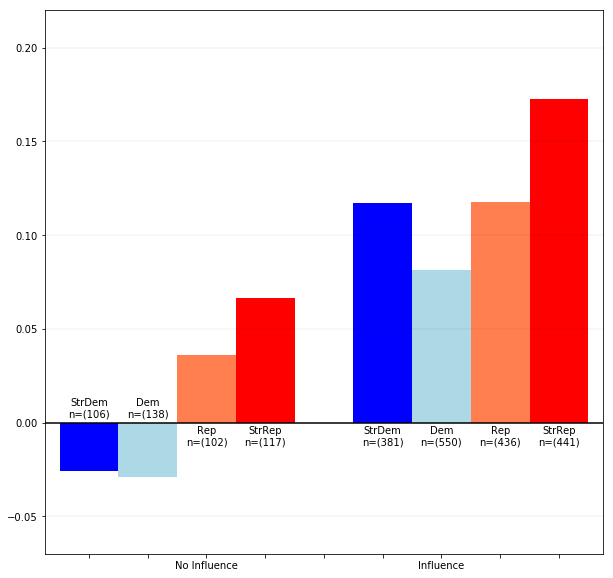

In [376]:
plt.figure(figsize =(10,10))

plt.plot(range(-1,10),[0]*11,'k')
for i in range(-1,5):
    plt.plot(range(-1,10),[i * 0.05]*11,'k',alpha=.04)
    
plt.bar(range(9),[0]*0 + [list(ind_data['conf'])[0]] + [0] * 4 + [list(inf_data['conf'])[0]] + [0]*3, 
        color='blue', width=1, tick_label=['','','No Influence','','','','Influence','',''])
plt.bar(range(9),[0]*1 + [list(ind_data['conf'])[1]] + [0] * 4 + [list(inf_data['conf'])[1]] + [0]*2, 
        color='lightblue', width=1)
plt.bar(range(9),[0]*2 + [list(ind_data['conf'])[2]] + [0] * 4 + [list(inf_data['conf'])[2]] + [0]*1, 
        color='coral', width=1)
plt.bar(range(9),[0]*3 + [list(ind_data['conf'])[3]] + [0] * 4 + [list(inf_data['conf'])[3]] + [0]*0, 
        color='red', width=1)

plt.text(0,0.0075,'StrDem\nn=('+str(len(answer_data[(answer_data['pol']==2) & (answer_data['world']<=2)]['user_order'].unique()))+')',
         horizontalalignment='center',verticalalignment='center')
plt.text(1,0.0075,'Dem\nn=('+str(len(answer_data[(answer_data['pol']==1) & (answer_data['world']<=2)]['user_order'].unique()))+')',
         horizontalalignment='center',verticalalignment='center')
plt.text(2,-0.0075,'Rep\nn=('+str(len(answer_data[(answer_data['pol']==-1) & (answer_data['world']<=2)]['user_order'].unique()))+')',
         horizontalalignment='center',verticalalignment='center')
plt.text(3,-0.0075,'StrRep\nn=('+str(len(answer_data[(answer_data['pol']==-2) & (answer_data['world']<=2)]['user_order'].unique()))+')',
         horizontalalignment='center',verticalalignment='center')

plt.text(5,-0.0075,'StrDem\nn=('+str(len(answer_data[(answer_data['pol']==2) & (answer_data['world']>2)]['user_order'].unique()))+')',
         horizontalalignment='center',verticalalignment='center')
plt.text(6,-0.0075,'Dem\nn=('+str(len(answer_data[(answer_data['pol']==1) & (answer_data['world']>2)]['user_order'].unique()))+')',
         horizontalalignment='center',verticalalignment='center')
plt.text(7,-0.0075,'Rep\nn=('+str(len(answer_data[(answer_data['pol']==-1) & (answer_data['world']>2)]['user_order'].unique()))+')',
         horizontalalignment='center',verticalalignment='center')
plt.text(8,-0.0075,'StrRep\nn=('+str(len(answer_data[(answer_data['pol']==-2) & (answer_data['world']>2)]['user_order'].unique()))+')',
         horizontalalignment='center',verticalalignment='center')


plt.ylim(-.07,.22)
plt.xlim(-0.75,8.75)

plt.show()

# Figure 1B

In [394]:
ind_str_data = answer_data[answer_data['world'] <=2]

ind_str_data = ind_str_data[ind_str_data['response'] == 1].groupby('pol').count()[['world']].join(
               ind_str_data.groupby('pol').count()[['question']])

ind_str_data.columns = ['agree','total']

ind_str_data['%agree'] = ind_str_data['agree'] / ind_str_data['total']

ind_str_data.head()

,agree,total,%agree
pol,,,
-2.0,1066,2175,0.490115
-1.0,884,1860,0.475269
1.0,1222,2575,0.474563
2.0,868,2012,0.431412


In [395]:
inf_str_data = answer_data[answer_data['world'] > 2]

inf_str_data = inf_str_data[inf_str_data['response'] == 1].groupby(['pol']).count()[['world']].join(
               inf_str_data.groupby('pol').count()[['question']])

inf_str_data.columns = ['agree','total']

inf_str_data['%agree'] = inf_str_data['agree'] / inf_str_data['total']

inf_str_data.head()

,agree,total,%agree
pol,,,
-2.0,4292,8380,0.512172
-1.0,4121,8285,0.497405
1.0,4722,10382,0.454826
2.0,3126,7086,0.441152


In [396]:
print(abs(ind_str_data.loc[-2,'%agree'] - ind_str_data.loc[2,'%agree']))
print(abs(ind_str_data.loc[-1,'%agree'] - ind_str_data.loc[1,'%agree']))
print()
print(abs(inf_str_data.loc[-2,'%agree'] - inf_str_data.loc[2,'%agree']))
print(abs(inf_str_data.loc[-1,'%agree'] - inf_str_data.loc[1,'%agree']))


0.0587034117136
0.000705710408185

0.0710202712397
0.0425792889067


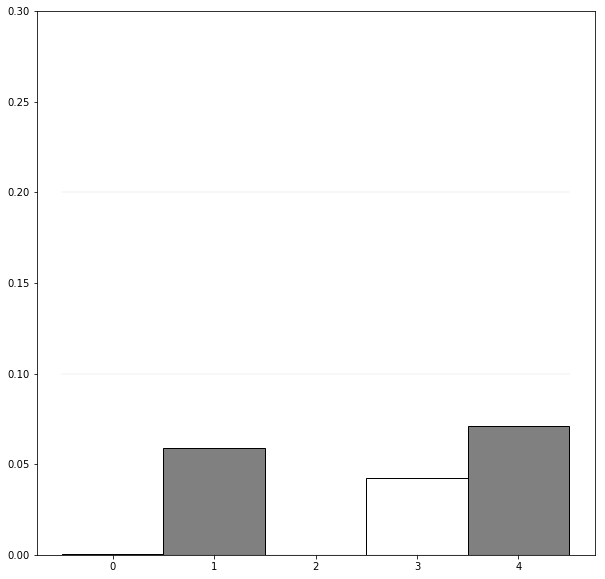

In [491]:
plt.figure(figsize =(10,10))

for i in range(0,3):
    plt.plot(np.arange(-0.5,5.,0.5),[i * 0.1]*11,'k',alpha=.04)
    
    
plt.bar(range(5), 
        [abs(ind_str_data.loc[-1,'%agree'] - ind_str_data.loc[1,'%agree'])] + 
        [0]*2 + 
        [abs(inf_str_data.loc[-1,'%agree'] - inf_str_data.loc[1,'%agree'])] + 
        [0],
        color='white', width=1, linewidth=1, edgecolor='k')#, tick_label=['','','No Influence','','','','Influence','',''])
plt.bar(range(5), 
        [0] + 
        [abs(ind_str_data.loc[-2,'%agree'] - ind_str_data.loc[2,'%agree'])] + 
        [0]*2 + 
        [abs(inf_str_data.loc[-2,'%agree'] - inf_str_data.loc[2,'%agree'])],
        color='grey', width=1, linewidth=1, edgecolor='k')
plt.ylim(0,0.3)

plt.show()


In [409]:
a = answer_data[answer_data['pol'].apply(lambda x: abs(x)==2)]
print(len(a[a['world'] <= 2]['user_order'].unique()))
print(len(a[a['world'] > 2]['user_order'].unique()))
print(len(a['user_order'].unique()))

223
822
1045


In [410]:
a = answer_data[answer_data['pol'].apply(lambda x: abs(x)==1)]
print(len(set(a[a['world'] <= 2]['user_order'])))
print(len(set(a[a['world'] > 2]['user_order'])))
print(len(a['user_order'].unique()))

240
986
1226


In [444]:
user_data.head()

,mturk,political_stand,session,question_id_sequence,current_question,world,sequential_number,aid,user_id,user_key
0,5c34e423-8d6e-4a62-b4be-f8755748a2eb,strong Democrats,5c34e45b496f8,"23,18,17,6,15,12,14,20,8,9,7,3,5,4,11,10,1,2,1...",13.0,7,0,5c34e423-8d6e-4a62-b4be-f8755748a2eb,5c34e423-8d6e-4a62-b4be-f8755748a2eb,0
1,5c34ea5d-82ff-4f65-bee8-2ca4eb2848db,Republicans,5c34ea9142404,"23,17,2,9,20,12,10,14,16,18,4,19,15,11,5,3,1,8...",25.0,1,0,5c34ea5d-82ff-4f65-bee8-2ca4eb2848db,5c34ea5d-82ff-4f65-bee8-2ca4eb2848db,1
2,5c34f29d-90b0-4c04-b78c-959b16f1c0d6,strong Democrats,5c34f394e1529,"23,14,2,20,9,11,15,3,1,17,8,5,18,19,6,4,12,10,...",16.0,9,0,5c34f29d-90b0-4c04-b78c-959b16f1c0d6,5c34f29d-90b0-4c04-b78c-959b16f1c0d6,2
3,5c34f45d-408d-4388-a655-f44a14991304,strong Democrats,5c34f483e59f0,"24,12,16,20,6,1,4,17,8,2,18,5,14,11,9,15,10,19...",25.0,3,0,5c34f45d-408d-4388-a655-f44a14991304,5c34f45d-408d-4388-a655-f44a14991304,3
4,5c34f905-a310-47cd-bf2b-324cf95e4adb,strong Democrats,5c34f9467bdc5,"24,15,14,5,16,3,4,12,1,17,8,18,19,9,2,11,7,6,1...",13.0,8,0,5c34f905-a310-47cd-bf2b-324cf95e4adb,5c34f905-a310-47cd-bf2b-324cf95e4adb,4


In [456]:
b = pd.read_csv('answers_final.csv')[['user_id','world_id','question_id','user_political_stand']]
b = b.join(user_data[['user_id','political_stand','user_key']].set_index('user_id'),on='user_id').reset_index()
b = b.dropna()
b = b[b['world_id']>0]
b = b[(b['question_id'] >= 1) & (a['question_id'] <= 20)]

b.head()

,index,user_id,world_id,question_id,user_political_stand,political_stand,user_key
1,1,5c34e423-8d6e-4a62-b4be-f8755748a2eb,7,18,disagree,strong Democrats,0.0
2,2,5c34e423-8d6e-4a62-b4be-f8755748a2eb,7,17,agree,strong Democrats,0.0
3,3,5c34e423-8d6e-4a62-b4be-f8755748a2eb,7,6,agree,strong Democrats,0.0
4,4,5c34e423-8d6e-4a62-b4be-f8755748a2eb,7,15,disagree,strong Democrats,0.0
5,5,5c34e423-8d6e-4a62-b4be-f8755748a2eb,7,12,disagree,strong Democrats,0.0


In [459]:
a = b[(b['world_id'] <= 2)& (b['world_id'] > 0)] 
a = a[(a['political_stand'].apply(lambda x: x=='strong Democrats')) | (a['political_stand'].apply(lambda x: x=='strong Republicans'))]
print(len(set(a.user_id)))

a = b[b['world_id'] > 2]
a = a[(a['political_stand'].apply(lambda x: x=='strong Democrats')) | (a['political_stand'].apply(lambda x: x=='strong Republicans'))]
print(len(set(a.user_id)))

223
822


In [463]:
a = b[(b['world_id'] <= 2)& (b['world_id'] > 0)] 
a = a[(a['political_stand'].apply(lambda x: x=='Democrats')) | (a['political_stand'].apply(lambda x: x=='Republicans'))]
print(len(set(a.user_id)))

a = b[b['world_id'] > 2]
a = a[(a['political_stand'].apply(lambda x: x=='Democrats')) | (a['political_stand'].apply(lambda x: x=='Republicans'))]
print(len(set(a.user_id)))


240
986


# Figure 2

In [508]:
wq_data = answer_data.copy()
wq_data['pol_bin'] = wq_data['pol'].apply(lambda x: 1 if x > 0 else -1)

#Get proportions in each world
wq_data = wq_data.groupby(['world','question','pol_bin']).mean()[['response']]
wq_data = wq_data.to_dict()['response']

In [556]:
def check_disagreement(per1,per2):
    if ((per1 > 0.5) & (per2 < 0.5)) | ((per1 < 0.5) & (per2 > 0.5)):
        result = 1
    else:
        result = 0
    return result
        
#Reorganize the Data
wq_results_dict = {w:{q:{} for q in range(1,21)} for w in range(1,11)}

for world in range(1,11):
    for question in range(1,21):
        wq_results_dict[world][question]['D%'] = wq_data[(world,question,-1)]
        wq_results_dict[world][question]['R%'] = wq_data[(world,question,+1)]
        wq_results_dict[world][question]['delta_agree'] = wq_data[(world,question,-1)] - wq_data[(world,question,+1)]
        wq_results_dict[world][question]['disagree'] = check_disagreement(wq_data[(world,question,-1)],wq_data[(world,question,+1)])
        wq_results_dict[world][question]['significant'] = 0

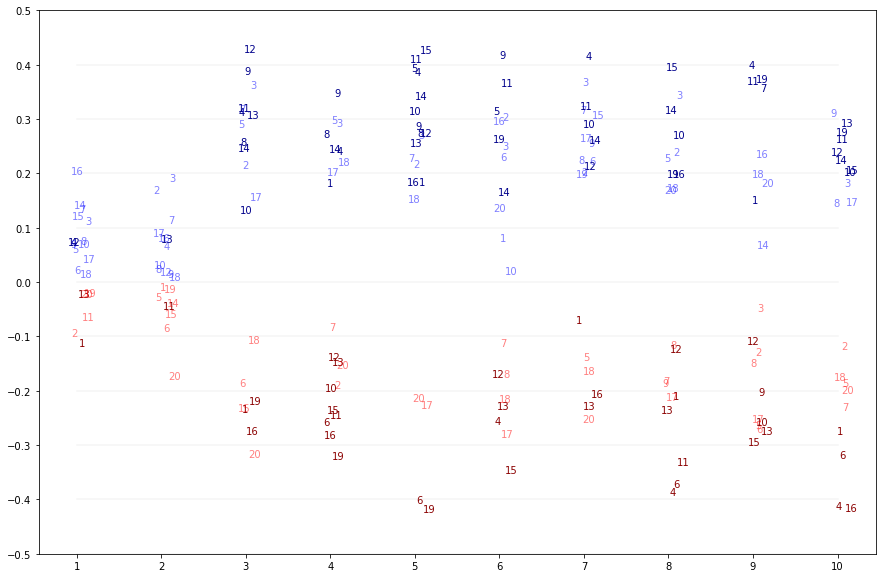

In [571]:
plt.figure(figsize=(15,10))

for i in np.arange(-.5,.6,.1):
    plt.plot(range(1,11),[i]*10, color='k', alpha=0.04)
for w in range(1,11):
    for q in range(1,21):
        if wq_results_dict[w][q]['significant'] == 0:
            if wq_results_dict[w][q]['delta_agree'] > 0:
                color = 'blue'
            else:
                color = 'red'
                
            if wq_results_dict[w][q]['disagree'] == 1:
                plt.text(x=w + random.uniform(-.1, .1),
                         y=wq_results_dict[w][q]['delta_agree'],
                         s=str(q),
                         color='dark'+color)
            else:
                plt.text(x=w + random.uniform(-.1, .1),
                         y=wq_results_dict[w][q]['delta_agree'],
                         s=str(q),
                         color=color,
                         alpha=0.5)

plt.ylim(-.5,.5)
plt.yticks(np.arange(-.5,.6,.1))
plt.xticks(range(1,11))

plt.show()

In [554]:
wq_results_dict

{1: {1: {'D%': 0.39000000000000001,
   'R%': 0.50819672131147542,
   'delta_agree': -0.11819672131147541,
   'disagree': 0,
   'significant': 0},
  2: {'D%': 0.24509803921568626,
   'R%': 0.34453781512605042,
   'delta_agree': -0.099439775910364153,
   'disagree': 0,
   'significant': 0},
  3: {'D%': 0.29702970297029702,
   'R%': 0.19008264462809918,
   'delta_agree': 0.10694705834219784,
   'disagree': 0,
   'significant': 0},
  4: {'D%': 0.54639175257731953,
   'R%': 0.47899159663865548,
   'delta_agree': 0.067400155938664053,
   'disagree': 0,
   'significant': 0},
  5: {'D%': 0.69999999999999996,
   'R%': 0.64406779661016944,
   'delta_agree': 0.055932203389830515,
   'disagree': 0,
   'significant': 0},
  6: {'D%': 0.66666666666666663,
   'R%': 0.65000000000000002,
   'delta_agree': 0.016666666666666607,
   'disagree': 0,
   'significant': 0},
  7: {'D%': 0.34653465346534651,
   'R%': 0.21848739495798319,
   'delta_agree': 0.12804725850736332,
   'disagree': 0,
   'significant': 0

In [555]:
check_disagreement(wq_data[(2,13,-1)],wq_data[(2,13,+1)])

0

In [ ]:
#To DO:
#Error Bars
#Fix Chart 1B
#Get Bonferri P Test
#Try Chart 4